# **Lab 11 - Transformers (Part 1: Machine Translation)**

Hi deep learners! This recitation will walk you through how to implement a transformer from scratch.

Transformers emerged from the goal to (1) reduce sequential/recurrent computation in deep learning architectures and (2) mitigate the problem of compressing lengthy input sequences into a single representation to be passed from an encoder to a decoder in sequence-to-sequence modeling.


While the concept of "attention" had been used before, Vaswani et al.'s 2017 paper "Attention is All You Need" introduced the Transformer architecture as one that relied entirely on attention, without any use of convolutions or recurrence.

This seminal paper has influenced a wave of transformer-based models and applications. In this notebook, we will walk through the implementation of a transformer for a language task: the task we will take up is Machine Translation from English to German using the Multi30k Dataset.

---

**Outline**:
- Dataset and Tokenization
- Model Architecture
  - Building Blocks
    - Positional Encoding
    - Multi-Head Self Attention
    - Add and Norm
    - Feed-Forward
  - Encoder
  - Decoder
  - Language Transformer Encoder-Decoder
- Training and Experiments

---

References:
- The Annotated Transformer: https://nlp.seas.harvard.edu/annotated-transformer/
- Attention is all you need: https://arxiv.org/pdf/1706.03762.pdf

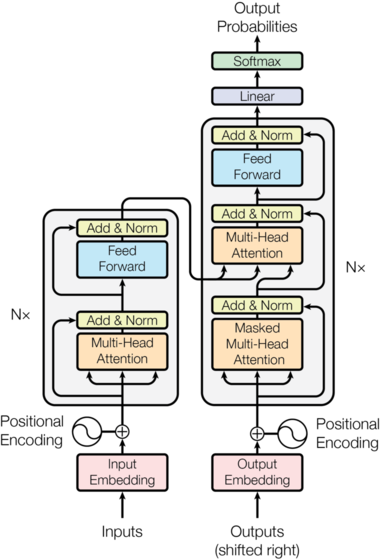

# **Libraries**

In [ ]:
!nvidia-smi

Wed Mar 27 22:38:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Uncomment to install
!pip install -U torchtext -q
!python -m spacy download "de_core_news_sm"
!python -m spacy download "en_core_web_sm"
!pip install portalocker>=2.0 -q
!pip install -U torchdata -q
!pip install sacrebleu -q
!pip install torchsummaryX -q
# You may need to restart your runtime after this

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 95.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR

import sacrebleu
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from typing import Tuple
import torchdata
import spacy
import random

from torchsummaryX import summary

In [ ]:
print(torch.__version__)

2.2.2+cu121


# **Dataset and Tokenization**

In [ ]:
# Use this cell if you get a UTF Encoding Error
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!git clone --recursive https://github.com/multi30k/dataset.git multi30k-dataset

fatal: destination path 'multi30k-dataset' already exists and is not an empty directory.


In [ ]:
!mkdir Multi30k
!mkdir Multi30k/train/
!mkdir Multi30k/val/
!mkdir Multi30k/test/

!gunzip -c /content/multi30k-dataset/data/task1/raw/train.en.gz > Multi30k/train/train.en
!gunzip -c /content/multi30k-dataset/data/task1/raw/train.de.gz > Multi30k/train/train.de
!gunzip -c /content/multi30k-dataset/data/task1/raw/val.en.gz > Multi30k/val/val.en
!gunzip -c /content/multi30k-dataset/data/task1/raw/val.de.gz > Multi30k/val/val.de
!gunzip -c /content/multi30k-dataset/data/task1/raw/test_2016_flickr.en.gz > Multi30k/test/test.en
!gunzip -c /content/multi30k-dataset/data/task1/raw/test_2016_flickr.de.gz > Multi30k/test/test.de

mkdir: cannot create directory ‘Multi30k’: File exists
mkdir: cannot create directory ‘Multi30k/train/’: File exists
mkdir: cannot create directory ‘Multi30k/val/’: File exists
mkdir: cannot create directory ‘Multi30k/test/’: File exists


In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import Multi30k
from collections import Counter
from tqdm import tqdm

root = '/content/Multi30k/'

# Tokenizers for English and German
en_tokenizer = get_tokenizer("spacy", language="en_core_web_sm")
de_tokenizer = get_tokenizer("spacy", language="de_core_news_sm")

# Functions to tokenize English and German texts
def tokenize_en(text):
    doc = en_tokenizer(str(text))
    return [token for token in doc]

def tokenize_de(text):
    doc = de_tokenizer(str(text))
    return [token for token in doc]


class Vocab:

    def __init__(self, tokenizer, min_freq=2, data = None, special_tokens=['<pad>', '<sos>', '<eos>', '<unk>']):
        self.tokenizer = tokenizer
        self.min_freq = min_freq
        self.special_tokens = special_tokens
        self.build_vocab(data)

    def build_vocab(self, data):
        counter = Counter()
        for text in tqdm(data):
            tokens = self.tokenizer(text)
            counter.update(tokens)

        # Filter out tokens with frequency less than min_freq
        tokens = [token for token, freq in counter.items() if freq >= self.min_freq]

        # Add special tokens
        tokens = self.special_tokens + tokens

        # Create dictionary with string-to-index mapping
        self.stoi = {token: index for index, token in enumerate(tokens)}
        self.itos = tokens

    def __len__(self):
        return len(self.stoi)

    def __getitem__(self, token):
        return self.stoi.get(token, self.stoi['<unk>'])

en_file = "Multi30k/train/train.en"
de_file = "Multi30k/train/train.de"

# Open the English text file and read its contents
with open(en_file, "r", encoding="utf8") as f:
    train_data_en = [text.strip() for text in f.readlines()]

# Open the German text file and read its contents
with open(de_file, "r", encoding="utf8") as f:
    train_data_de = [text.strip() for text in f.readlines()]

EN_VOCAB = Vocab(tokenize_en, min_freq=1, data = train_data_en)
DE_VOCAB = Vocab(tokenize_de, min_freq=1, data = train_data_de)
print("\nVocab Size English", len(EN_VOCAB))
print("\nVocab Size German", len(DE_VOCAB))

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
100%|██████████| 29000/29000 [00:02<00:00, 14411.07it/s]



Vocab Size English 10837

Vocab Size German 19214


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class TranslationDataset(Dataset):

    def __init__(self, en_data, de_data, src_tokenizer, tgt_tokenizer, src_vocab, tgt_vocab):

        self.en_data = en_data
        self.de_data = de_data
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab

    def __getitem__(self, index):

        src_txt, tgt_txt = self.en_data[index], self.de_data[index]

        src_tokens = [self.src_vocab[token] for token in self.src_tokenizer(src_txt)]
        tgt_tokens = [self.tgt_vocab[token] for token in self.tgt_tokenizer(tgt_txt)]

        src_tokens = [self.src_vocab['<sos>']] + src_tokens + [self.src_vocab['<eos>']]
        tgt_tokens = [self.tgt_vocab['<sos>']] + tgt_tokens + [self.tgt_vocab['<eos>']]

        src_tensor = torch.LongTensor(src_tokens)
        tgt_tensor = torch.LongTensor(tgt_tokens)

        return src_tensor, tgt_tensor

    def __len__(self):

        assert len(self.en_data) == len(self.de_data)

        return len(self.en_data)

    def collate_fn(self, batch):

        src_tensors, tgt_tensors = zip(*batch)
        src_tensors = torch.nn.utils.rnn.pad_sequence(src_tensors, padding_value=self.src_vocab['<pad>'], batch_first=True)
        tgt_tensors = torch.nn.utils.rnn.pad_sequence(tgt_tensors, padding_value=self.tgt_vocab['<pad>'], batch_first=True)

        return src_tensors, tgt_tensors

In [ ]:
en_file = "Multi30k/train/train.en"
de_file = "Multi30k/train/train.de"

# Open the English text file and read its contents
with open(en_file, "r", encoding="utf8") as f:
    train_data_en = [text.strip() for text in f.readlines()]

# Open the German text file and read its contents
with open(de_file, "r", encoding="utf8") as f:
    train_data_de = [text.strip() for text in f.readlines()]

en_file = "Multi30k/val/val.en"
de_file = "Multi30k/val/val.de"

# Open the English text file and read its contents
with open(en_file, "r", encoding="utf8") as f:
    val_data_en = [text.strip() for text in f.readlines()]

# Open the German text file and read its contents
with open(de_file, "r", encoding="utf8") as f:
    val_data_de = [text.strip() for text in f.readlines()]

en_file = "Multi30k/test/test.en"
de_file = "Multi30k/test/test.de"

# Open the English text file and read its contents
with open(en_file, "r", encoding="utf8") as f:
    test_data_en = [text.strip() for text in f.readlines()]

# Open the German text file and read its contents
with open(de_file, "r", encoding="utf8") as f:
    test_data_de = [text.strip() for text in f.readlines()]

train_dataset     = TranslationDataset(train_data_en, train_data_de, tokenize_en, tokenize_de, EN_VOCAB, DE_VOCAB)
val_dataset       = TranslationDataset(val_data_en, val_data_de, tokenize_en, tokenize_de, EN_VOCAB, DE_VOCAB)
test_dataset      = TranslationDataset(test_data_en, test_data_de, tokenize_en, tokenize_de, EN_VOCAB, DE_VOCAB)

BATCH_SIZE = 128

train_dataloader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_dataset.collate_fn)
val_dataloader    = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=val_dataset.collate_fn)
test_dataloader   = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=test_dataset.collate_fn)

#### **Example Sequences**

In [ ]:
train_dataset[0]

(tensor([ 1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  2]),
 tensor([ 1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,  2]))

In [ ]:
' '.join([EN_VOCAB.itos[i] for i in train_dataset[0][0]]), ' '.join([DE_VOCAB.itos[i] for i in train_dataset[0][1]])

('<sos> Two young , White males are outside near many bushes . <eos>',
 '<sos> Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche . <eos>')

In [ ]:
test_data_en[0], test_data_de[0]

('A man in an orange hat starring at something.',
 'Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.')

In [ ]:
' '.join([EN_VOCAB.itos[i] for i in test_dataset[0][0]]), ' '.join([DE_VOCAB.itos[i] for i in test_dataset[0][1]])

('<sos> A man in an orange hat starring at something . <eos>',
 '<sos> Ein Mann mit einem orangefarbenen Hut , der etwas <unk> . <eos>')

#**Model Architecture**

##**Building Blocks**

### **Positional Encoding**

Positional Encoding is a technique used in the Transformer architecture to inject positional information into the input sequence. Since the Multi-Head Self-Attention mechanism is permutation-equivariant, it cannot capture the relative position of words in the input sequence by itself. Positional Encoding helps to address this issue by adding a fixed vector to each word's embeddings, which is computed based on its position in the sequence.

Desiderata:
- Unitary
- Norm preserving (magnitude of eigenvalues is 1)
- Learnable (optional)
- Unique rotated embedding at each time

The positional encoding function used in the Transformer is based on sine and cosine functions with different frequencies. This choice allows the model to learn to attend to both nearby and distant words, as well as to interpolate the positional encoding for longer sequences than those seen during training.

In [ ]:
import math

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_seq_len, dropout=0.1):
        """
        Initialize the PositionalEncoding module.

        Args:
        d_model (int): The dimensionality of the input.
        max_seq_len (int): The maximum length of the input sequence.
        dropout (float, optional): The dropout probability. Defaults to 0.1.
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(max_seq_len, d_model)

        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # Registering the buffer allows you to capture it in a state_dict
        # even though it is not a learnable parameter.
        # Source: https://pytorch.org/docs/stable/notes/modules.html
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Forward pass for PositionalEncoding.

        Args:
        x (Tensor): The input tensor of shape (batch_size, seq_length, d_model).

        Returns:
        Tensor: The output tensor of shape (batch_size, seq_length, d_model).
        """
        x = x + self.pe[:, :x.size(1), :]
        x = self.dropout(x)
        return x

### **Multi-Head Self Attention**

#### **Self-Attention**

Since the fundamental mechanism that powers transformers is **Self-Attention**, we will first implement a **Multi-Head Self-Attention** block.

The idea behind self-attention is to compute a weighted sum of all words in the input sequence, where the weights are determined by how relevant each word in the entire sequence is to the current one. This mechanism allows the model to consider the entire context when processing each word.

#### **Multi-Head Self Attention**

Multi-Head Self-Attention is a key component of the Transformer architecture. It is designed to capture the dependencies between words in an input sequence without requiring sequential processing, which is the main drawback of RNNs and LSTMs.

In Multi-Head Self-Attention, this process is performed multiple times (in parallel) with different linear projections of the input, which allows the model to capture different types of relationships between words (like Subject-Verb, Adjective-Adverb, Subject-Object, etc). These multiple attention "heads" are then concatenated and projected to create the final output of the self-attention layer.

The computation of the self-attention weights involves three learnable vectors for each word: Query (Q), Key (K), and Value (V). The dot product between the query and the key determines the relevance score of each word, which is then normalized using the softmax function. Finally, the weighted sum of the value vectors produces the output for each word.

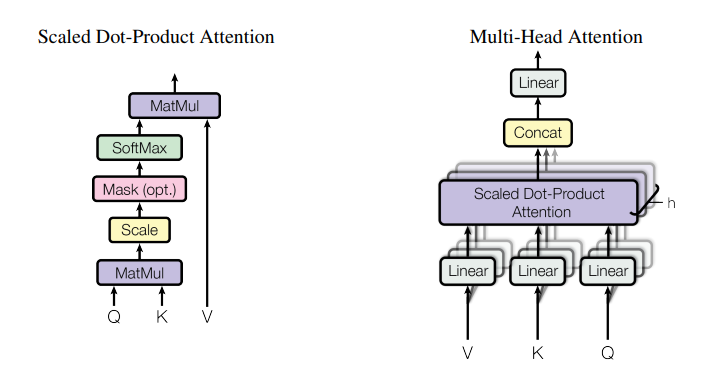


*(From the Paper)*
The Transformer uses multi-head attention in three different ways:

* **Self-Attention in the Encoder**: The encoder contains self-attention layers. In a self-attention layer all of the keys, values and queries come from the same place, in this case, the output of the previous layer in the encoder. Each position in the encoder can attend to *all positions* in the previous layer of the encoder.

* **Cross-Attention**: In "encoder-decoder attention" layers, *queries come from the previous decoder layer, and the memory keys and values come from the output of the encoder*. This allows every position in the decoder to attend over all positions in the input sequence. This mimics the typical encoder-decoder attention mechanisms in sequence-to-sequence models.

* **Masked Self-Attention in the Decoder**: Similar to the encoder, there are self-attention layers in the decoder that allow each position in the decoder to attend to other position. However, rather than attend to all positions, *it may only attend to positions up to and including that position*. This is why it is called a "masked" self-attention: the "future" is masked (you may also see this referred to as "causal masking"). That is, we need to prevent leftward information flow in the decoder to preserve the auto-regressive property. We implement this inside of scaled dot-product attention by masking out (setting to −∞) all values in the input of the softmax which correspond to "illegal" connections. The values −∞ go to zero after taking the softmax.

A visualization of some learned cross-attention weights at various layers and is different heads is below. (The Annotated Transformer)

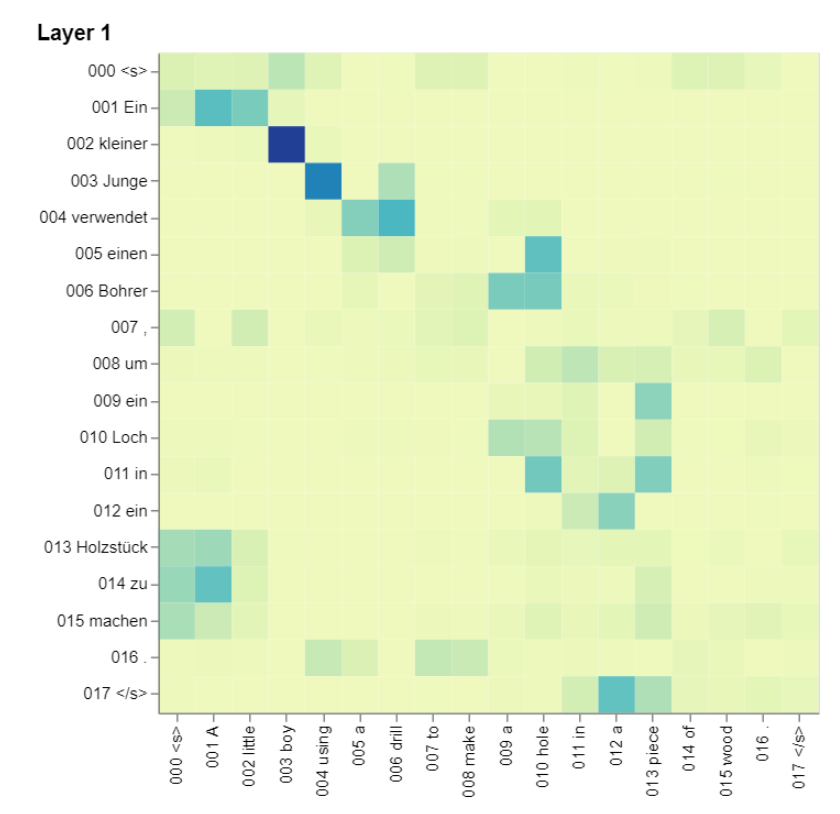


**A note on masking**: When we attend to sequences, attending to padding tokens in the input sequences is undesired for the Encoder, while attending to the future tokens in the target sequences is not desired in the decoder. To prevent this, we create source and target masks that can be used to nullify the influence of these tokens when calculating our context and attention weights. The source mask is used to prevent attention to the padding tokens in the source sequence, while the target mask ensures that the decoder only attends to the previous tokens in the target sequence during training (causal masking).

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadSelfAttention(nn.Module):

    def __init__(self, d_model, num_heads):
        """
        Initialize the MultiHeadSelfAttention module.

        Args:
        d_model (int): The dimensionality of the input.
        num_heads (int): The number of attention heads.
        """
        super(MultiHeadSelfAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads

        assert self.head_dim * num_heads == d_model, "Invalid number of heads or d_model dimensions"

        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)

        self.wo = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        """
        Forward pass for MultiHeadSelfAttention.

        Args:
        q (Tensor): The input query tensor of shape   (batch_size, seq_length, d_model).
        k (Tensor): The input key tensor of shape     (batch_size, seq_length, d_model).
        v (Tensor): The input value tensor of shape   (batch_size, seq_length, d_model).
        mask (Tensor, optional): The mask tensor for ignoring certain elements. Defaults to None.

        Returns:
        Tensor: The output tensor of shape (batch_size, seq_length, d_model).
        """
        batch_size = q.size(0)

        q = self.wq(q).view(batch_size, -1, self.num_heads, self.head_dim)
        k = self.wk(k).view(batch_size, -1, self.num_heads, self.head_dim)
        v = self.wv(v).view(batch_size, -1, self.num_heads, self.head_dim)

        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        attn = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)

        if mask is not None:
            attn = attn.masked_fill(mask == 0, float('-inf'))

        attn = F.softmax(attn, dim=-1)

        out = torch.matmul(attn, v).transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        out = self.wo(out)

        return out

### **Add and Norm**

The Add & Norm module is crucial for maintaining a stable gradient flow in deep networks, such as the Transformer. It consists of two parts: residual connections and layer normalization.

The Add & Norm module is applied after both the Multi-Head Self-Attention layer and the Position-wise Feed-Forward layer in the Transformer.

In [ ]:
class AddNorm(nn.Module):

    def __init__(self, d_model, eps=1e-6):
        """
        Initialize the AddNorm module.

        Args:
        d_model (int): The dimensionality of the input.
        eps (float, optional): A small constant for numerical stability. Defaults to 1e-6.
        """
        super(AddNorm, self).__init__()
        self.norm = nn.LayerNorm(d_model, eps=eps)

    def forward(self, x, residual):
        """
        Forward pass for AddNorm.

        Args:
        x (Tensor): The input tensor of shape (batch_size, seq_length, d_model).
        residual (Tensor): The residual tensor of the same shape as the input tensor.

        Returns:
        Tensor: The output tensor of shape (batch_size, seq_length, d_model).
        """
        out = x + residual
        out = self.norm(out)

        return out

### **Feed-Forward**

An FFN consists of two linear layers with a non-linear activation function in between, such as ReLU (Rectified Linear Unit). The output of the first linear layer increases the dimensionality of the input, while the second linear layer reduces it back to the original dimension. This expansion and reduction allow the FFN to learn complex patterns and relationships between features.

The FFN is applied after the Multi-Head Self-Attention layer in both the encoder and decoder blocks of the Transformer.

In [ ]:
class PositionwiseFeedForward(nn.Module):

    def __init__(self, d_model, d_ff, dropout=0.1):
        """
        Initialize the PositionwiseFeedForward module.

        Args:
        d_model (int): The dimensionality of the input.
        d_ff (int): The dimensionality of the hidden layer in the feed-forward network.
        dropout (float, optional): The dropout probability. Defaults to 0.1.
        """
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        """
        Forward pass for PositionwiseFeedForward.

        Args:
        x (Tensor): The input tensor of shape (batch_size, seq_length, d_model).

        Returns:
        Tensor: The output tensor of shape (batch_size, seq_length, d_model).
        """
        out = self.linear1(x)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.linear2(out)

        return out

## **Encoder**

The Encoder Block in the Transformer architecture consists of the following layers:

- Multi-Head Self-Attention layer
- Add & Norm (Residual connection and Layer Normalization)
- Position-wise Feed-Forward Network layer
- Add & Norm (Residual connection and Layer Normalization)

In the Transformer, multiple encoder blocks (6 according to the paper) are stacked on top of each other to form the complete encoder module.

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        """
        Initialize the EncoderBlock module.

        Args:
        d_model (int): The dimensionality of the input.
        num_heads (int): The number of attention heads.
        d_ff (int): The dimensionality of the hidden layer in the feed-forward network.
        dropout (float, optional): The dropout probability. Defaults to 0.1.
        """
        super(EncoderBlock, self).__init__()
        self.self_attn = MultiHeadSelfAttention(d_model, num_heads)
        self.norm1 = AddNorm(d_model)
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.norm2 = AddNorm(d_model)

    def forward(self, x, mask=None):
        """
        Forward pass for EncoderBlock.

        Args:
        x (Tensor): The input tensor of shape (batch_size, seq_length, d_model).
        mask (Tensor, optional): The mask tensor for ignoring certain elements. Defaults to None.

        Returns:
        Tensor: The output tensor of shape (batch_size, seq_length, d_model).
        """
        x1 = self.self_attn(q=x, k=x, v=x, mask)
        x = self.norm1(x, x1)
        x1 = self.ffn(x)
        x = self.norm2(x, x1)

        return x

## **Decoder**

The Decoder Block in the Transformer architecture consists of the following layers:

- Masked Multi-Head Self-Attention layer
- Add & Norm (Residual connection and Layer Normalization)
- Encoder-Decoder Multi-Head Attention layer
- Add & Norm (Residual connection and Layer Normalization)
- Position-wise Feed-Forward Network layer
- Add & Norm (Residual connection and Layer Normalization)

In the Transformer, multiple decoder blocks are stacked on top of each other to form the complete decoder module.

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        """
        Initialize the DecoderBlock module.

        Args:
        d_model (int): The dimensionality of the input.
        num_heads (int): The number of attention heads.
        d_ff (int): The dimensionality of the hidden layer in the feed-forward network.
        dropout (float, optional): The dropout probability. Defaults to 0.1.
        """
        super(DecoderBlock, self).__init__()
        self.self_attn = MultiHeadSelfAttention(d_model, num_heads)
        self.norm1 = AddNorm(d_model)
        self.enc_dec_attn = MultiHeadSelfAttention(d_model, num_heads)
        self.norm2 = AddNorm(d_model)
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.norm3 = AddNorm(d_model)

    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        """
        Forward pass for DecoderBlock.

        Args:
        x (Tensor): The target input tensor of shape (batch_size, seq_length, d_model).
        enc_output (Tensor): The encoder output tensor of shape (batch_size, seq_length, d_model).
        src_mask (Tensor, optional): The source mask tensor for ignoring certain elements. Defaults to None.
        tgt_mask (Tensor, optional): The target mask tensor for ignoring certain elements. Defaults to None.

        Returns:
        Tensor: The output tensor of shape (batch_size, seq_length, d_model).
        """
        x1 = self.self_attn(q=x, k=x, v=x, tgt_mask)
        x = self.norm1(x, x1)
        x1 = self.enc_dec_attn(q=x, k=enc_output, v=enc_output, src_mask)
        x = self.norm2(x, x1)
        x1 = self.ffn(x)
        x = self.norm3(x, x1)

        return x

## **Language Transformer Encoder-Decoder**

Now that we have implemented all the building blocks, let's assemble the complete Transformer architecture.

We initialize the following components:

- Source and target embedding layers
- Positional encoding module
- Encoder and decoder layer stacks
- Final linear layer to produce the probability distribution over the target vocabulary

In the forward method, we first pass the source and target input tensors through their respective embedding layers and add the positional encoding. Then, we pass the source input through each encoder layer sequentially, followed by passing the target input and encoder output through each decoder layer sequentially. Finally, we apply the linear layer to produce the output tensor with shape (batch_size, tgt_seq_length, tgt_vocab_size).

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, D_MODEL, num_heads, d_ff, max_seq_len, num_layers, dropout=0.1):
        """
        Initialize the Transformer module.

        Args:
        src_vocab_size (int): The size of the source vocabulary.
        tgt_vocab_size (int): The size of the target vocabulary.
        d_model (int): The dimensionality of the embedding
        num_heads (int): The number of attention heads.
        d_ff (int): The dimensionality of the hidden layer in the feed-forward network.
        max_seq_len (int): The maximum length of the input sequence.
        num_layers (int): The number of layers in the encoder and decoder.
        dropout (float, optional): The dropout probability. Defaults to 0.1.
        """
        super(Transformer, self).__init__()

        self.src_embedding = nn.Embedding(src_vocab_size, D_MODEL)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, D_MODEL)
        self.pos_encoding = PositionalEncoding(D_MODEL, max_seq_len, dropout)

        self.encoder_layers = nn.ModuleList([EncoderBlock(D_MODEL, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderBlock(D_MODEL, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(D_MODEL, tgt_vocab_size)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        """
        Forward pass for Transformer.

        Args:
        src (Tensor): The source input tensor of shape (batch_size, src_seq_length).
        tgt (Tensor): The target input tensor of shape (batch_size, tgt_seq_length).
        src_mask (Tensor, optional): The source mask tensor for ignoring certain elements. Defaults to None.
        tgt_mask (Tensor, optional): The target mask tensor for ignoring certain elements. Defaults to None.

        Returns:
        Tensor: The output tensor of shape (batch_size, tgt_seq_length, tgt_vocab_size).
        """
        src = self.src_embedding(src)
        src = self.pos_encoding(src)

        tgt = self.tgt_embedding(tgt)
        tgt = self.pos_encoding(tgt)

        for layer in self.encoder_layers:
            src = layer(src, src_mask)

        for layer in self.decoder_layers:
            tgt = layer(tgt, src, src_mask, tgt_mask)

        out = self.fc(tgt)

        return out

#**Training Setup**

## **Hyperparameters and Model**



In [ ]:
# Define Hyper Parameters
NUM_EPOCHS      = 20
D_MODEL         = 256
ATTN_HEADS      = 8
NUM_LAYERS      = 3
FEEDFORWARD_DIM = 512
DROPOUT         = 0.1
MAX_SEQ_LEN     = 150
SRC_VOCAB_SIZE  = len(EN_VOCAB)
TGT_VOCAB_SIZE  = len(DE_VOCAB)
LR              = 0

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class NoamScheduler:

    def __init__(self, optimizer, d_model, warmup_steps=4000):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.current_step = 0

    def step(self):
        self.current_step += 1
        lr = self.learning_rate()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

    def learning_rate(self):
        step = self.current_step
        return (self.d_model ** -0.5) * min(step ** -0.5, step * self.warmup_steps ** -1.5)

In [ ]:
model = Transformer(SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, D_MODEL, ATTN_HEADS, FEEDFORWARD_DIM, MAX_SEQ_LEN, NUM_LAYERS, DROPOUT).to(DEVICE)
# optimizer = Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, betas=(0.9, 0.98), eps=1e-9, weight_decay=5e-2)
warmup_steps = 2 * len(train_dataloader)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)
# scheduler = LambdaLR(optimizer, lr_lambda=lambda step: (D_MODEL ** -0.5) * min((step + 1) ** -0.5, (step + 1) * warmup_steps ** -1.5), verbose=True)
scheduler = NoamScheduler(optimizer, d_model=D_MODEL, warmup_steps=warmup_steps)
criterion = torch.nn.CrossEntropyLoss(ignore_index=DE_VOCAB['<pad>'], label_smoothing=0.1)
scaler = torch.cuda.amp.GradScaler()

## Helper Functions

In [ ]:
import sacrebleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

def generate_tgt_mask(tgt, pad_idx):
    seq_len = tgt.size(1)
    no_future_mask = torch.tril(torch.ones((seq_len, seq_len), device=DEVICE)).bool()
    pad_mask = (tgt != pad_idx).unsqueeze(1).unsqueeze(2)
    combined_mask = pad_mask & no_future_mask
    return combined_mask

def generate_src_mask(src, pad_idx):
    mask = (src != pad_idx).unsqueeze(1).unsqueeze(2)
    return mask

def calculate_bleu(tgt_output, output):
    tgt_output = tgt_output.cpu().numpy()
    output = output.cpu().numpy()

    refs = []
    hyps = []

    excluded_tokens = (DE_VOCAB['<pad>'], DE_VOCAB['<eos>'], DE_VOCAB['<sos>'])
    for tgt, pred in zip(tgt_output, output):
        ref = ' '.join([DE_VOCAB.itos[t] for t in tgt if t not in excluded_tokens])
        hyp = ' '.join([DE_VOCAB.itos[t] for t in pred if t not in excluded_tokens])

        refs.append(ref)
        hyps.append(hyp)

    bleu = sacrebleu.corpus_bleu(hyps, [refs], force=True).score
    return bleu

## Model Summary

In [ ]:
src, tgt = next(iter(train_dataloader))
src, tgt = src.to(DEVICE), tgt.to(DEVICE)

src_mask = generate_src_mask(src, EN_VOCAB['<pad>'])

tgt_input = tgt[:, :-1]
tgt_output = tgt[:, 1:]
tgt_mask = generate_tgt_mask(tgt_input, DE_VOCAB['<pad>'])

summary(model, src, tgt_input, src_mask, tgt_mask)

                                            Kernel Shape      Output Shape  \
Layer                                                                        
0_src_embedding                             [256, 10837]    [128, 31, 256]   
1_pos_encoding.Dropout_dropout                         -    [128, 31, 256]   
2_tgt_embedding                             [256, 19214]    [128, 33, 256]   
3_pos_encoding.Dropout_dropout                         -    [128, 33, 256]   
4_encoder_layers.0.self_attn.Linear_wq        [256, 256]    [128, 31, 256]   
5_encoder_layers.0.self_attn.Linear_wk        [256, 256]    [128, 31, 256]   
6_encoder_layers.0.self_attn.Linear_wv        [256, 256]    [128, 31, 256]   
7_encoder_layers.0.self_attn.Linear_wo        [256, 256]    [128, 31, 256]   
8_encoder_layers.0.norm1.LayerNorm_norm            [256]    [128, 31, 256]   
9_encoder_layers.0.ffn.Linear_linear1         [256, 512]    [128, 31, 512]   
10_encoder_layers.0.ffn.Dropout_dropout                -    [128

/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_src_embedding,"[256, 10837]","[128, 31, 256]",2774272.0,2774272.0
1_pos_encoding.Dropout_dropout,-,"[128, 31, 256]",NaN,NaN
2_tgt_embedding,"[256, 19214]","[128, 33, 256]",4918784.0,4918784.0
3_pos_encoding.Dropout_dropout,-,"[128, 33, 256]",NaN,NaN
4_encoder_layers.0.self_attn.Linear_wq,"[256, 256]","[128, 31, 256]",65792.0,65536.0
...,...,...,...,...
69_decoder_layers.2.ffn.Linear_linear1,"[256, 512]","[128, 33, 512]",131584.0,131072.0
70_decoder_layers.2.ffn.Dropout_dropout,-,"[128, 33, 512]",NaN,NaN
71_decoder_layers.2.ffn.Linear_linear2,"[512, 256]","[128, 33, 256]",131328.0,131072.0


## Train and Validate Functions

In [ ]:
def train_epoch(model, dataloader, optimizer, criterion, device):

    model.train()
    total_loss = 0

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True,
                     leave=False, position=0, desc='Train')

    for i, (src, tgt) in enumerate(dataloader):

        src, tgt = src.to(device), tgt.to(device)
        src_mask = generate_src_mask(src, EN_VOCAB['<pad>'])

        tgt_input   = tgt[:, :-1]
        tgt_output  = tgt[:, 1:]

        tgt_mask = generate_tgt_mask(tgt_input, DE_VOCAB['<pad>'])

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():

            output = model(src, tgt_input, src_mask, tgt_mask)

            loss = criterion(output.reshape(-1, output.size(2)), tgt_output.reshape(-1))

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        scheduler.step()

        total_loss += loss.item()

        batch_bar.set_postfix(
            loss="{:.04f}".format(total_loss / (i + 1)),
            lr="{:.09f}".format(float(optimizer.param_groups[0]['lr'])))
        batch_bar.update()

    return total_loss / len(dataloader)

def validate_epoch(model, dataloader, criterion, DEVICE):

    model.eval()
    epoch_loss = 0
    epoch_bleu_score = 0

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True,
                     leave=False, position=0, desc='Validate')

    with torch.no_grad():

        for i, (src, tgt) in enumerate(dataloader):

            src, tgt = src.to(DEVICE), tgt.to(DEVICE)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            src_mask = generate_src_mask(src, EN_VOCAB['<pad>'])
            tgt_mask = generate_tgt_mask(tgt_input, DE_VOCAB['<pad>'])

            with torch.cuda.amp.autocast():

                output = model(src, tgt_input, src_mask, tgt_mask)
                loss = criterion(output.reshape(-1, output.shape[-1]), tgt_output.reshape(-1))

            epoch_loss += loss.item()
            epoch_bleu_score += calculate_bleu(tgt_output, output.argmax(-1))

            batch_bar.set_postfix(
            loss="{:.04f}".format(epoch_loss / (i + 1)),
            bleu="{:.04f}".format(epoch_bleu_score / (i + 1)))

            batch_bar.update()

    # Normalize the loss and BLEU score by the number of validation samples
    epoch_loss /= len(dataloader)
    epoch_bleu_score /= len(dataloader)

    return epoch_loss, epoch_bleu_score

## Inference

In [ ]:
def inference(model, src, de_tokenizer):

    model.eval()

    src_mask = generate_src_mask(src, EN_VOCAB['<pad>'])

    # Initialize target input tensors with <sos> tokens
    tgt_input = torch.full((src.size(0), 1), DE_VOCAB['<sos>'], dtype=torch.long, device=DEVICE)

    # Create a flag for each sequence in the batch
    eos_flags = torch.zeros(src.size(0), dtype=torch.bool, device=DEVICE)

    # Perform inference for each target token
    with torch.no_grad():

        for _ in range(70):

            tgt_mask = generate_tgt_mask(tgt_input, DE_VOCAB['<pad>'])
            output = model(src, tgt_input, src_mask, tgt_mask)
            next_tokens = output.argmax(2)[:, -1].unsqueeze(1)
            tgt_input = torch.cat((tgt_input, next_tokens), dim=1)

            # Update the eos_flags for sequences that have generated <eos>
            eos_flags |= (next_tokens.squeeze() == DE_VOCAB['<eos>'])

            # Stop generating tokens if all sequences have generated <eos> or reached maximum length
            if torch.all(eos_flags):
                break

    # Convert target input tensors to translated sentences
    translated_sentences = []
    for i in range(tgt_input.size(0)):

        translated_tokens = []

        for token in tgt_input[i][1:]:

            if token == DE_VOCAB['<eos>']:

                break

            else:

                translated_tokens.append(DE_VOCAB.itos[token.item()])

        translated_sentence = ' '.join(translated_tokens)
        translated_sentences.append(translated_sentence)

    return translated_sentences

# **Training**

In [ ]:
best_val_loss = float('inf')
train_losses = []
val_losses = []
bleu_scores = []

for epoch in range(1, NUM_EPOCHS + 1):

    print(f"Epoch {epoch}/{NUM_EPOCHS}")

    # Training
    train_loss = train_epoch(model, train_dataloader, optimizer, criterion, DEVICE)
    train_losses.append(train_loss)

    # Validation
    val_loss, bleu_score = validate_epoch(model, val_dataloader, criterion, DEVICE)
    val_losses.append(val_loss)
    bleu_scores.append(bleu_score)

    # Update learning rate
    # scheduler.step()

    # Print results
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | BLEU Score: {bleu_score:.4f}")

    # Save the model with the best validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1/20


Train Loss: 5.7906 | Val Loss: 4.2075 | BLEU Score: 7.0167
Epoch 2/20


Train Loss: 3.8065 | Val Loss: 3.6509 | BLEU Score: 13.5288
Epoch 3/20


Train Loss: 3.3043 | Val Loss: 3.3404 | BLEU Score: 13.2025
Epoch 4/20


Train Loss: 2.9296 | Val Loss: 3.1565 | BLEU Score: 14.0160
Epoch 5/20


Train Loss: 2.6676 | Val Loss: 3.0706 | BLEU Score: 15.5092
Epoch 6/20


Train Loss: 2.4718 | Val Loss: 3.0364 | BLEU Score: 15.5645
Epoch 7/20


Train Loss: 2.3125 | Val Loss: 3.0354 | BLEU Score: 16.2683
Epoch 8/20


Train Loss: 2.1850 | Val Loss: 3.0376 | BLEU Score: 16.0331
Epoch 9/20


Train Loss: 2.0811 | Val Loss: 3.0656 | BLEU Score: 17.6558
Epoch 10/20


Train Loss: 1.9991 | Val Loss: 3.0452 | BLEU Score: 17.4562
Epoch 11/20


Train Loss: 1.9377 | Val Loss: 3.0604 | BLEU Score: 17.8499
Epoch 12/20


Train Loss: 1.8832 | Val Loss: 3.0830 | BLEU Score: 16.4894
Epoch 13/20


Train Loss: 1.8423 | Val Loss: 3.1129 | BLEU Score: 16.7051
Epoch 14/20


Train Loss: 1.8060 | Val Loss: 3.1124 | BLEU Score: 17.5326
Epoch 15/20


Train Loss: 1.7727 | Val Loss: 3.1329 | BLEU Score: 18.7815
Epoch 16/20


Train Loss: 1.7450 | Val Loss: 3.1394 | BLEU Score: 16.3143
Epoch 17/20


Train Loss: 1.7197 | Val Loss: 3.1563 | BLEU Score: 16.2850
Epoch 18/20


Train Loss: 1.6983 | Val Loss: 3.1604 | BLEU Score: 16.5386
Epoch 19/20


Train Loss: 1.6806 | Val Loss: 3.1767 | BLEU Score: 16.5053
Epoch 20/20


Train Loss: 1.6651 | Val Loss: 3.1905 | BLEU Score: 16.7109


# Evaluate Test Set

In [ ]:
def evaluate_test_set_bleu(model, test_dataloader, de_tokenizer):

    translated_sentences = []
    ground_truth_sentences = []

    for batch in tqdm(test_dataloader, desc="Evaluating"):
        src, tgt_output = batch
        src, tgt = src.to(DEVICE), tgt_output.to(DEVICE)
        tgt_sentences = [' '.join([DE_VOCAB.itos[token.item()] for token in sequence if token.item() not in [DE_VOCAB['<pad>'], DE_VOCAB['<sos>'], DE_VOCAB['<eos>']]]) for sequence in tgt_output]

        translations = inference(model, src, de_tokenizer)
        translated_sentences.extend(translations)
        ground_truth_sentences.extend([[tgt] for tgt in tgt_sentences])

    rand_index = random.randint(0, len(test_dataset))
    print("\n\nExample Sentence and its Translation")
    print("Source Sentence in English               :", ' '.join([EN_VOCAB.itos[i] for i in test_dataset[rand_index][0] if EN_VOCAB.itos[i] not in ['<pad>', '<sos>', '<eos>']]))
    print("Ground Truth Sentence in German          :", ground_truth_sentences[rand_index][0])
    print("Machine Translated Sentence in German    :", translated_sentences[rand_index])
    bleu_score = sacrebleu.corpus_bleu(translated_sentences, ground_truth_sentences)

    return bleu_score

# Usage example
test_bleu = evaluate_test_set_bleu(model, test_dataloader, de_tokenizer)
print("Test BLEU score:", test_bleu.score)

Evaluating: 100%|██████████| 8/8 [00:04<00:00,  1.64it/s]



Example Sentence and its Translation
Source Sentence in English               : A young boy is hanging onto a clothing rack .
Ground Truth Sentence in German          : Ein kleiner Junge hängt von einer <unk> .
Machine Translated Sentence in German    : Ein kleiner Junge hängt an einem mit .
Test BLEU score: 26.97022371900737
